In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Analysis imports
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def fip_score(data):
    # Calculating the pct_change for the fip calculation
    
    data = data.pct_change().dropna()

    # set variables for the number of 
    # positive / negative / zero and number of data. 
    # Determine the cumulativ returns and set to a variable. 

    num_positive = len(data[data > 0])
    num_negative = len(data[data < 0])
    num_zero = len(data[data == 0])
    num_days = len(data)
    cum_returns = data.sum() 
        
    # Perform the Fip Score calculation

    score = (np.sign(cum_returns) * 
                 (num_negative / num_days - 
                  num_positive / num_days))
    return score

In [3]:
df = pd.read_csv('../Data/crude_wti_futures_history_data.csv',
                parse_dates = True,
                infer_datetime_format = True,
                index_col = 'Date')
df = df.sort_index()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2001-09-24,22.01,25.90,25.90,21.80,108.96K,-15.25%
2001-09-25,21.81,22.15,23.15,21.25,90.61K,-0.91%
2001-09-26,22.38,22.17,22.50,20.30,82.37K,2.61%
2001-09-27,22.74,22.71,22.94,21.95,56.83K,1.61%
2001-09-28,23.43,22.76,23.52,22.76,60.08K,3.03%
...,...,...,...,...,...,...
2020-09-16,40.16,38.35,40.34,38.35,367.61K,4.91%
2020-09-17,40.97,40.19,41.22,39.42,280.67K,2.02%
2020-09-18,41.11,40.97,41.49,40.30,73.76K,0.34%


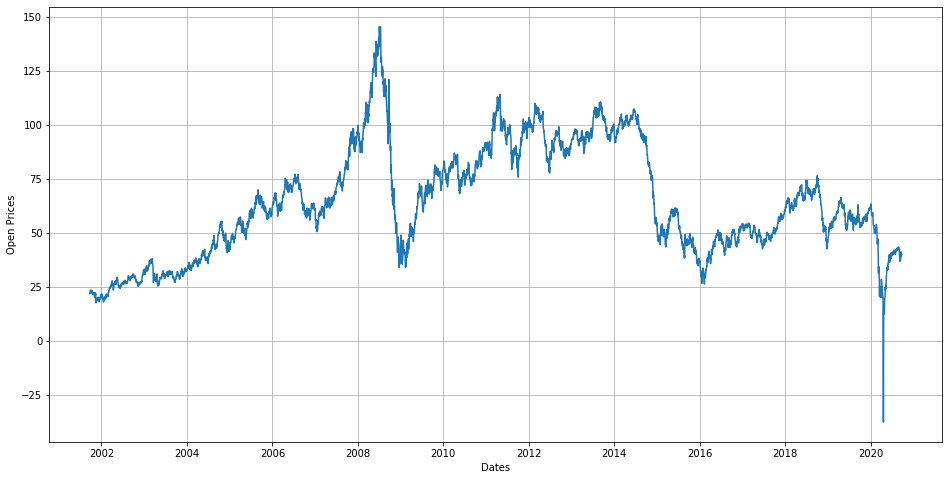

In [4]:
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(df['Price']);

### Seasonal decompose

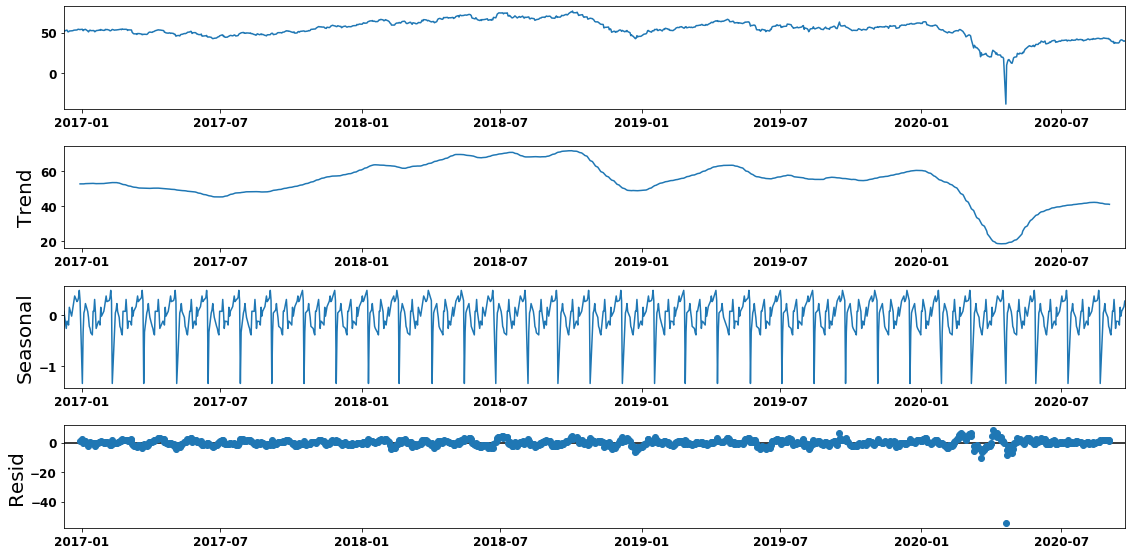

In [40]:
prices = df[['Price']]
result = seasonal_decompose(prices[-1000:], model='additive', period=30)
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 20
matplotlib.rc('figure', figsize=(16, 8))
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
fig = result.plot()


### Train-Test Split

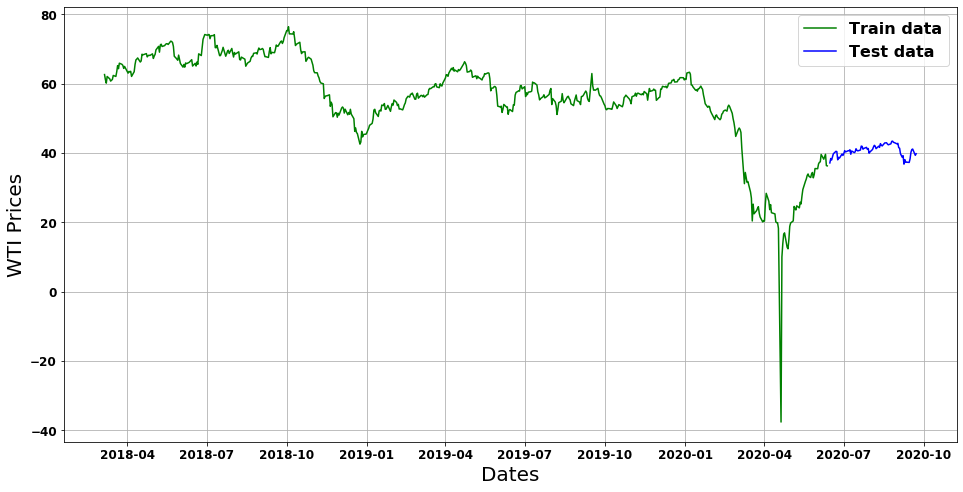

In [46]:
# Manually splitting the data
window_size = 73
train_data, test_data = prices[0:-window_size], prices[-window_size:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('WTI Prices')
plt.plot(train_data.tail(600), 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### ARIMA model

In [7]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [8]:
train_arima = train_data['Price']
test_arima = test_data['Price']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    

In [9]:
predictions_df = test_data.copy()
predictions_df['Price'] = np.array(predictions)

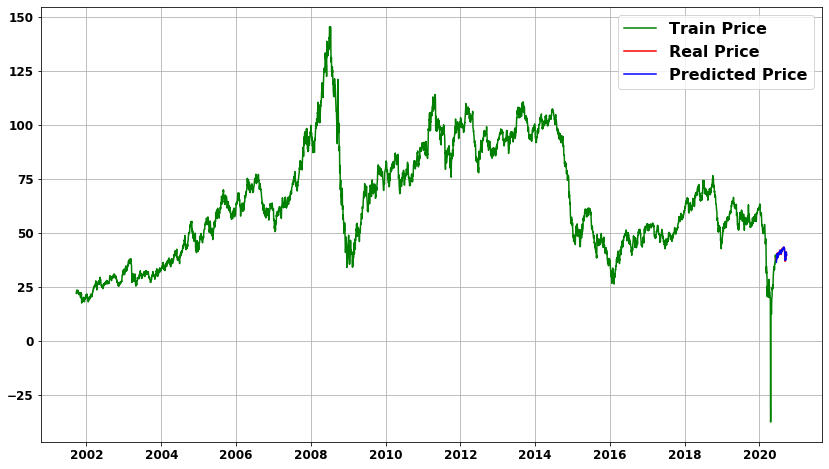

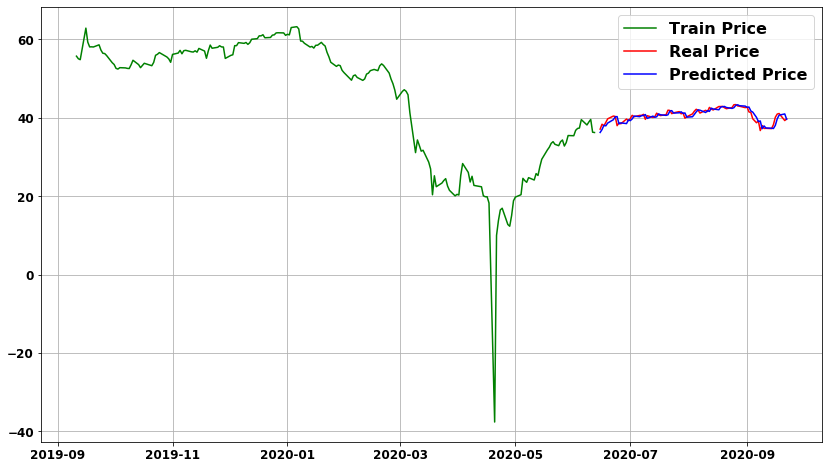

MSE: 0.6847914128390801
MAE: 0.6161542470759562
RMSE: 0.8275212461556984


In [45]:
plt.figure(figsize=(14,8))
plt.plot(train_arima, color='green', label = 'Train Price')
plt.plot(test_data, color = 'red', label = 'Real Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(train_arima.tail(200), color='green', label = 'Train Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

### Deep Learning--LSTM

In [11]:
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
from numpy.random import seed
seed(1)

In [12]:
# Feature Scaling
scaler = MinMaxScaler()
train = train_data.iloc[:, 0:1].values
train_scaled = scaler.fit_transform(train) 

X_train = []
y_train = []

timesteps = 30
for i in range(timesteps, train.shape[0]):
    # take TIMESTEPS previous prices
    X_train.append(train_scaled[i-timesteps:i, 0])
    # present price as y value
    y_train.append(train_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, 
                     (X_train.shape[0], 
                      X_train.shape[1], 
                      1))

In [55]:
model = Sequential()
# Initial model setup
number_units_1 = 30
number_units_2 = 30
dropout_fraction = 0.2
# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = number_units_1, 
               return_sequences = True, 
               input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(dropout_fraction))

model.add(LSTM(units = number_units_2))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 35, batch_size = 30)

Epoch 1/35
159/159 [==============================] - 3s 18ms/step - loss: 0.0115
Epoch 2/35
159/159 [==============================] - 3s 18ms/step - loss: 0.0051
Epoch 3/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0043
Epoch 4/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0038
Epoch 5/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0033
Epoch 6/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0029
Epoch 7/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0025
Epoch 8/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0023
Epoch 9/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0020
Epoch 10/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0017
Epoch 11/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0015
Epoch 12/35
159/159 [==============================] - 3s 17ms/step - loss: 0.0014
Epoch 13/35
1

In [56]:
# this will be used later while comparing and visualization
real_price = test_data.iloc[:,0:1].values 
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, 
# we will need prices on timesteps previous dates  
#combine = pd.concat([train_data, test_data], axis = 0)

combine = pd.concat([train_data, predictions_df[['Price']]], axis = 0)
# test inputs also contains the Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_price = scaler.inverse_transform(predicted_price)

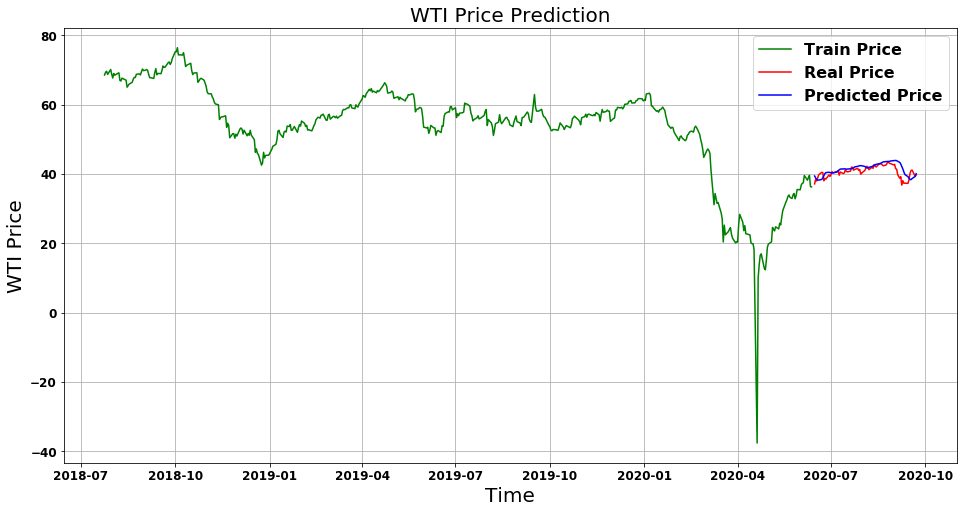

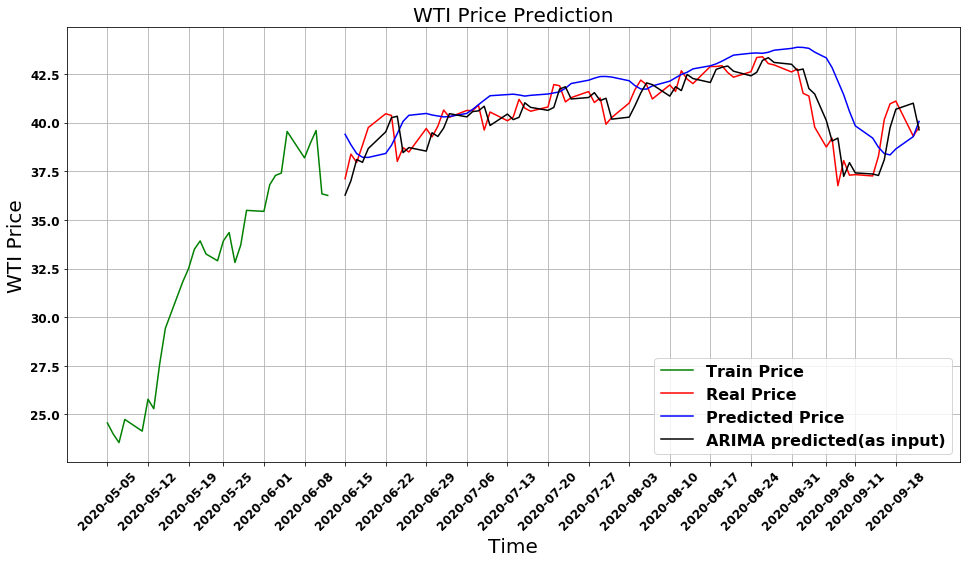

MSE(mean_squared_error): 2.674537168085552
MAE(mean_absolute_error): 1.1882375701486245
RMSE(sqrt_mean_squared_error): 1.6354012254139814


In [57]:
plt.figure(figsize=(16,8))
plt.plot(train_data.tail(500), color='green', label = 'Train Price')
plt.plot(test_data.index, real_price, color = 'red', label = "Real Price")
plt.plot(test_data.index, predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('WTI Price Prediction')
plt.xlabel('Time')
plt.ylabel('WTI Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16,8))
plt.plot(train_data.tail(30), color='green', label = 'Train Price')
plt.plot(test_data.index, real_price, color = 'red', label = "Real Price")
plt.plot(test_data.index, predicted_price, color = 'blue', label = 'Predicted Price')
plt.plot(test_data.index, predictions, color = 'black', label = 'ARIMA predicted(as input)')
plt.title('WTI Price Prediction')
plt.xlabel('Time')
plt.xticks(combine.index[-103:-1:5],rotation=45)
plt.ylabel('WTI Price')
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(real_price, predicted_price)
print('MSE(mean_squared_error): '+str(mse))
mae = mean_absolute_error(real_price, predicted_price)
print('MAE(mean_absolute_error): '+str(mae))
rmse = sqrt(mean_squared_error(real_price, predicted_price))
print('RMSE(sqrt_mean_squared_error): '+str(rmse))